In [1]:
import os, glob
import thinkdsp
import thinkplot
import pickle
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import signalprocessing as sigp
import soundmfccparams as smfccp

from graphviz import Source
from scipy.io.wavfile import write
from IPython.display import SVG
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

In [2]:
# Path for signal/noise packs
signalPath = r"/home/vaclav/Desktop/Diploma/Clean Signals/ETHALON_SIGNAL"
noisePath = r"/home/vaclav/Desktop/Diploma/Clean Signals/ETHALON_NOISE"

In [3]:
## This is signal data extracting
signalMaxAmp = sigp.calculate_mean_amplitude_list(signalPath)
signalMaxAmpSplit = sigp.split_calculate_mean_amplitude_list(signalPath)
signalSco = sigp.calculate_SCO_amplitude_list(signalPath)
signalCrestFactor = sigp.calculate_CRFACT_list(signalPath)
signalCentroid = sigp.calculate_CENTROID_list(signalPath)
signalSpread = sigp.calculate_SPREAD_list(signalPath)
signalFlatness = sigp.calculate_FLATNESS_list(signalPath)
# Extracting MFCC params (in Dataframe)
signalMfcc = smfccp.compute_mfcc(signalPath)
#signalMfccDelta = smfccp.compute_mfcc_delta(signalPath)

## This is noise data extracting
noiseMaxAmp = sigp.calculate_mean_amplitude_list(noisePath)
noiseMaxAmpSplit = sigp.split_calculate_mean_amplitude_list(noisePath)
noiseSco = sigp.calculate_SCO_amplitude_list(noisePath)
noiseCrestFactor = sigp.calculate_CRFACT_list(noisePath)
noiseCentroid = sigp.calculate_CENTROID_list(noisePath)
noiseSpread = sigp.calculate_SPREAD_list(noisePath)
noiseFlatness = sigp.calculate_FLATNESS_list(noisePath)
# Extracting MFCC params (in Dataframe)
noiseMfcc = smfccp.compute_mfcc(noisePath)
#noiseMfccDelta = smfccp.compute_mfcc_delta(signalPath)

/home/vaclav/Desktop/Diploma/Notebooks/Classifier/signalprocessing.py:339: RuntimeWarning: divide by zero encountered in log
  return (np.exp((1 / length) * np.sum(np.log(magnitudes)))) / ((1 / length) * np.sum(magnitudes))


In [4]:
# Signal splitted amps
sigLst1 = [item[0] for item in signalMaxAmpSplit]
sigLst2 = [item[1] for item in signalMaxAmpSplit]
sigLst3 = [item[2] for item in signalMaxAmpSplit]
sigLst4 = [item[3] for item in signalMaxAmpSplit]

# Noise splitted amps
noiseLst1 = [item[0] for item in noiseMaxAmpSplit]
noiseLst2 = [item[1] for item in noiseMaxAmpSplit]
noiseLst3 = [item[2] for item in noiseMaxAmpSplit]
noiseLst4 = [item[3] for item in noiseMaxAmpSplit]

In [5]:
#signalDataFrame = {'Total MaxAmp': signalMaxAmp, 'Split MaxAmp 1': sigLst1, 'Split MaxAmp 2': sigLst2, 'Split MaxAmp 3': sigLst3, 'Split MaxAmp 4': sigLst4, 'SCO': signalSco, 'Crest Factor': signalCrestFactor}
signalDataFrame = {'Total MaxAmp': signalMaxAmp, 'Split MaxAmp 1': sigLst1, 'Split MaxAmp 2': sigLst2, 'Split MaxAmp 3': sigLst3, 'Split MaxAmp 4': sigLst4, 'SCO': signalSco, 'Crest Factor': signalCrestFactor, 'Centroid': signalCentroid, 'Spread': signalSpread, 'Flatness': signalFlatness}
signalDataFrame = pd.DataFrame(data=signalDataFrame)
signalDataFrame = pd.concat([signalDataFrame,signalMfcc], axis=1)
#signalDataFrame = pd.concat([signalDataFrame,signalMfccDelta], axis=1)
signalDataFrame.head()

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Crest Factor,Centroid,Spread,Flatness,...,MFCC_10,MFCC_11,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19
0,150491.537060,81973.574809,74724.705839,70135.186372,71275.026723,4768.996440,261.852373,3178.265733,4.567400e+06,0.003763,...,-4.458062,1.067613,0.516805,7.727972,6.373898,-3.611062,14.580167,-0.361103,1.332859,-1.833363
1,82042.583804,32661.802768,41841.660856,44661.436320,39588.490420,1772.640815,141.590455,2037.383653,4.821699e+06,0.004385,...,-14.146482,8.015750,0.375979,5.550191,7.088860,2.664846,9.060751,0.021489,5.768086,-3.603709
2,89231.836813,47440.002631,46963.024971,46181.307541,35778.529911,1867.283805,164.032435,1966.114572,4.505704e+06,0.004202,...,-13.892034,9.431018,-2.065030,5.973203,8.321308,3.307363,8.581530,-2.927097,8.331109,-5.322766
3,85986.484422,43968.692152,43148.724241,39989.575746,38523.098552,1826.254177,152.404728,2090.248768,5.341053e+06,0.004395,...,-16.257206,10.635303,-1.006228,8.676380,6.649755,2.188552,8.476087,-1.288104,7.784525,-5.613897
4,265757.244039,7634.898074,82612.244272,169295.802777,176952.319908,4826.593254,143.077590,6255.840716,2.338890e+06,0.002094,...,-12.395898,6.572901,3.467196,2.015535,9.064105,-0.054644,9.150679,-3.157119,7.528465,-6.519304


In [6]:
noiseDataFrame = {'Total MaxAmp': noiseMaxAmp, 'Split MaxAmp 1': noiseLst1, 'Split MaxAmp 2': noiseLst2, 'Split MaxAmp 3': noiseLst3, 'Split MaxAmp 4': noiseLst4, 'SCO': noiseSco, 'Crest Factor': noiseCrestFactor, 'Centroid': noiseCentroid, 'Spread': noiseSpread, 'Flatness': noiseFlatness}
#noiseDataFrame = {'Total MaxAmp': noiseMaxAmp, 'SCO': noiseSco}
noiseDataFrame = pd.DataFrame(data=noiseDataFrame)
noiseDataFrame = pd.concat([noiseDataFrame,noiseMfcc], axis=1)
#noiseDataFrame = pd.concat([noiseDataFrame,noiseMfccDelta], axis=1)
noiseDataFrame.head()

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Crest Factor,Centroid,Spread,Flatness,...,MFCC_10,MFCC_11,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19
0,58572.629848,12712.880668,51331.128619,13430.951514,13240.955752,698.882228,104.834003,2548.586441,3.134702e+06,0.005459,...,-13.017824,5.814240,-4.908351,6.511048,5.945688,5.107234,10.404021,-0.300071,7.658782,-4.628345
1,84276.213591,43996.311645,35272.668624,36649.247568,49530.621587,1120.912389,136.423870,2812.977884,5.389564e+06,0.005038,...,-13.529956,7.614180,0.576080,6.227180,7.322908,1.919086,11.002797,-3.847258,10.830333,-9.096796
2,49003.089999,21320.580540,26510.360424,28879.748500,18536.076332,678.173577,103.303931,2300.508560,2.858825e+06,0.005720,...,-15.363314,2.465794,2.937236,4.740872,7.716486,1.514369,7.957967,-3.611988,8.380780,-3.083670
3,56074.745257,7221.676033,49630.376349,23879.049988,6358.469845,1000.198349,120.659812,1865.417237,3.021044e+06,0.005134,...,-6.178546,3.295416,4.865382,2.036165,9.009554,0.806819,9.648679,-1.223142,6.161716,-2.573241
4,55660.436938,2299.309245,8940.250692,46460.130380,29368.825568,1690.550653,190.681085,1298.239441,3.019843e+06,0.004173,...,-8.884585,6.534148,0.447894,6.931505,6.683308,3.135692,7.220325,-0.692991,6.260170,-3.643665


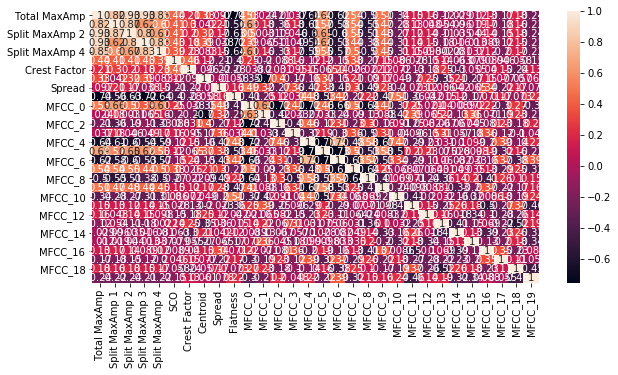

In [7]:
signalCorrMatrix = signalDataFrame.corr()
sn.heatmap(signalCorrMatrix, annot=True)

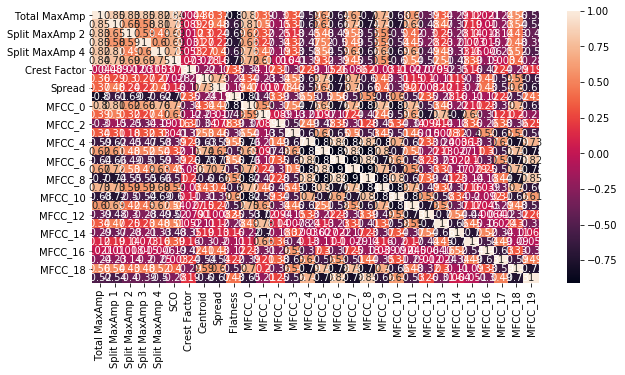

In [8]:
noiseCorrMatrix = noiseDataFrame.corr()
sn.heatmap(noiseCorrMatrix, annot=True)

In [9]:
# Using PCA to reduce components
#signalDataFrame = smfccp.pca_dataframe(signalDataFrame, 15)
#noiseDataFrame = smfccp.pca_dataframe(noiseDataFrame, 15)

In [10]:
#rng = range(0, int((len(list(signalDataFrame))-1)/2)+1)

#new_cols = ['type_' + str(i) for i in rng] + ['expt_' + str(i) for i in rng]

# ensure the length of the new columns list is equal to the length of df's columns
#signalDataFrame.columns = new_cols[:len(list(signalDataFrame))]
signalDataFrame

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Crest Factor,Centroid,Spread,Flatness,...,MFCC_10,MFCC_11,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19
0,150491.537060,81973.574809,74724.705839,70135.186372,71275.026723,4768.996440,261.852373,3178.265733,4.567400e+06,0.003763,...,-4.458062,1.067613,0.516805,7.727972,6.373898,-3.611062,14.580167,-0.361103,1.332859,-1.833363
1,82042.583804,32661.802768,41841.660856,44661.436320,39588.490420,1772.640815,141.590455,2037.383653,4.821699e+06,0.004385,...,-14.146482,8.015750,0.375979,5.550191,7.088860,2.664846,9.060751,0.021489,5.768086,-3.603709
2,89231.836813,47440.002631,46963.024971,46181.307541,35778.529911,1867.283805,164.032435,1966.114572,4.505704e+06,0.004202,...,-13.892034,9.431018,-2.065030,5.973203,8.321308,3.307363,8.581530,-2.927097,8.331109,-5.322766
3,85986.484422,43968.692152,43148.724241,39989.575746,38523.098552,1826.254177,152.404728,2090.248768,5.341053e+06,0.004395,...,-16.257206,10.635303,-1.006228,8.676380,6.649755,2.188552,8.476087,-1.288104,7.784525,-5.613897
4,265757.244039,7634.898074,82612.244272,169295.802777,176952.319908,4826.593254,143.077590,6255.840716,2.338890e+06,0.002094,...,-12.395898,6.572901,3.467196,2.015535,9.064105,-0.054644,9.150679,-3.157119,7.528465,-6.519304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,92513.363268,53570.047988,47299.770953,40433.846955,39342.743850,4301.132151,202.654809,2733.229751,4.195326e+06,0.004597,...,-3.843441,6.859174,-2.606430,0.789813,14.929559,-1.013988,5.501278,-0.445138,12.274665,-9.896340
310,67181.444955,14627.469452,26219.766105,46250.275357,19855.269059,1794.981240,112.552034,5287.803693,4.552231e+06,0.005029,...,-7.503268,1.503623,6.820916,-0.749205,10.613829,-0.397060,9.767618,-1.978881,7.251991,-2.918085
311,157098.324949,72840.651655,88111.439125,73822.497500,69795.218661,3141.175194,231.538138,2191.986406,4.202690e+06,0.003165,...,-13.287461,8.027717,-1.288218,11.200619,6.972423,1.955083,2.686978,-5.980018,7.731324,-0.072837
312,40048.798352,5786.449537,31604.378978,24981.913354,8106.505168,2937.193897,118.164546,3087.794786,3.122893e+06,0.005387,...,7.363627,-2.886717,6.239301,14.529841,0.715401,-3.349525,7.521462,2.872073,-6.620605,2.481946


In [11]:
#rng = range(0, int((len(list(noiseDataFrame))-1)/2)+1)

#new_cols = ['type_' + str(i) for i in rng] + ['expt_' + str(i) for i in rng]

# ensure the length of the new columns list is equal to the length of df's columns
#noiseDataFrame.columns = new_cols[:len(list(noiseDataFrame))]
noiseDataFrame

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Crest Factor,Centroid,Spread,Flatness,...,MFCC_10,MFCC_11,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19
0,58572.629848,12712.880668,51331.128619,13430.951514,13240.955752,698.882228,104.834003,2548.586441,3.134702e+06,0.005459,...,-13.017824,5.814240,-4.908351,6.511048,5.945688,5.107234,10.404021,-0.300071,7.658782,-4.628345
1,84276.213591,43996.311645,35272.668624,36649.247568,49530.621587,1120.912389,136.423870,2812.977884,5.389564e+06,0.005038,...,-13.529956,7.614180,0.576080,6.227180,7.322908,1.919086,11.002797,-3.847258,10.830333,-9.096796
2,49003.089999,21320.580540,26510.360424,28879.748500,18536.076332,678.173577,103.303931,2300.508560,2.858825e+06,0.005720,...,-15.363314,2.465794,2.937236,4.740872,7.716486,1.514369,7.957967,-3.611988,8.380780,-3.083670
3,56074.745257,7221.676033,49630.376349,23879.049988,6358.469845,1000.198349,120.659812,1865.417237,3.021044e+06,0.005134,...,-6.178546,3.295416,4.865382,2.036165,9.009554,0.806819,9.648679,-1.223142,6.161716,-2.573241
4,55660.436938,2299.309245,8940.250692,46460.130380,29368.825568,1690.550653,190.681085,1298.239441,3.019843e+06,0.004173,...,-8.884585,6.534148,0.447894,6.931505,6.683308,3.135692,7.220325,-0.692991,6.260170,-3.643665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,75711.499717,17418.042870,68947.880431,20773.443836,11354.554567,833.333211,126.450735,2732.141246,4.288213e+06,0.005189,...,-10.434360,4.722930,4.179940,-0.432659,12.539351,-3.583985,12.889967,-4.133275,8.145557,-4.148302
310,193309.112425,95744.345481,95894.469352,97896.223007,97550.041513,2457.200364,263.651742,2703.043271,5.006780e+06,0.003293,...,-16.626528,10.245478,-0.494975,3.698003,8.529514,-1.108651,11.290883,-3.575428,11.815619,-7.278941
311,75311.504988,14578.851503,12459.810816,70842.195601,14867.544036,942.370530,145.396700,2548.960259,4.134718e+06,0.005146,...,-10.686538,3.064195,6.026714,0.056822,10.853155,-0.873472,9.972828,-2.669231,7.909886,-4.711977
312,88012.740509,32533.228875,45537.516639,21184.475140,62455.300276,1097.668204,122.349923,2652.338549,4.502521e+06,0.004857,...,-10.850432,5.133152,5.048335,-0.526190,10.644738,-1.178085,10.416477,-2.384842,8.018136,-4.467659


In [12]:
# 1-es pack for final Dataframe (signals)
ones = {'Flag': np.ones(len(signalMaxAmp))}
onesFlag = pd.DataFrame(data=ones)

# 0-es pack for final Dataframe (noises)
zeroes = {'Flag': np.zeros(len(noiseMaxAmp))}
zeroesFlag = pd.DataFrame(data=zeroes)

# Adding "Flag" fields
signalDataFrame = signalDataFrame.assign(Flag=onesFlag['Flag'])
noiseDataFrame = noiseDataFrame.assign(Flag=zeroesFlag['Flag'])

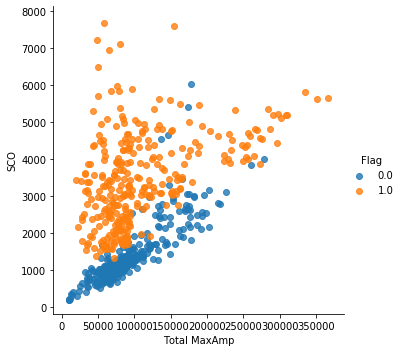

In [13]:
# Uniting signals & noises data in one Dataframe
learningDataframe = pd.merge(signalDataFrame, noiseDataFrame, how='outer')

# Visualizing the data (1 - signal, 0 - noise)
sn.lmplot('Total MaxAmp', 'SCO', data=learningDataframe, hue="Flag", fit_reg=False)
#sn.lmplot('type_0', 'type_2', data=learningDataframe, hue="Flag", fit_reg=False)

In [14]:
learningDataframe

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Crest Factor,Centroid,Spread,Flatness,...,MFCC_11,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19,Flag
0,150491.537060,81973.574809,74724.705839,70135.186372,71275.026723,4768.996440,261.852373,3178.265733,4.567400e+06,0.003763,...,1.067613,0.516805,7.727972,6.373898,-3.611062,14.580167,-0.361103,1.332859,-1.833363,1.0
1,82042.583804,32661.802768,41841.660856,44661.436320,39588.490420,1772.640815,141.590455,2037.383653,4.821699e+06,0.004385,...,8.015750,0.375979,5.550191,7.088860,2.664846,9.060751,0.021489,5.768086,-3.603709,1.0
2,89231.836813,47440.002631,46963.024971,46181.307541,35778.529911,1867.283805,164.032435,1966.114572,4.505704e+06,0.004202,...,9.431018,-2.065030,5.973203,8.321308,3.307363,8.581530,-2.927097,8.331109,-5.322766,1.0
3,85986.484422,43968.692152,43148.724241,39989.575746,38523.098552,1826.254177,152.404728,2090.248768,5.341053e+06,0.004395,...,10.635303,-1.006228,8.676380,6.649755,2.188552,8.476087,-1.288104,7.784525,-5.613897,1.0
4,265757.244039,7634.898074,82612.244272,169295.802777,176952.319908,4826.593254,143.077590,6255.840716,2.338890e+06,0.002094,...,6.572901,3.467196,2.015535,9.064105,-0.054644,9.150679,-3.157119,7.528465,-6.519304,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,75711.499717,17418.042870,68947.880431,20773.443836,11354.554567,833.333211,126.450735,2732.141246,4.288213e+06,0.005189,...,4.722930,4.179940,-0.432659,12.539351,-3.583985,12.889967,-4.133275,8.145557,-4.148302,0.0
624,193309.112425,95744.345481,95894.469352,97896.223007,97550.041513,2457.200364,263.651742,2703.043271,5.006780e+06,0.003293,...,10.245478,-0.494975,3.698003,8.529514,-1.108651,11.290883,-3.575428,11.815619,-7.278941,0.0
625,75311.504988,14578.851503,12459.810816,70842.195601,14867.544036,942.370530,145.396700,2548.960259,4.134718e+06,0.005146,...,3.064195,6.026714,0.056822,10.853155,-0.873472,9.972828,-2.669231,7.909886,-4.711977,0.0
626,88012.740509,32533.228875,45537.516639,21184.475140,62455.300276,1097.668204,122.349923,2652.338549,4.502521e+06,0.004857,...,5.133152,5.048335,-0.526190,10.644738,-1.178085,10.416477,-2.384842,8.018136,-4.467659,0.0


In [15]:
############################################################################## TRAIN ##############################################################################

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.8s finished


Average number of nodes 31
Average maximum depth 7
Recall Baseline: 1.0 Test: 0.97 Train: 1.0
Precision Baseline: 0.54 Test: 0.9 Train: 1.0
Roc Baseline: 0.5 Test: 0.99 Train: 1.0
Confusion matrix, without normalization
[[76 11]
 [ 3 99]]


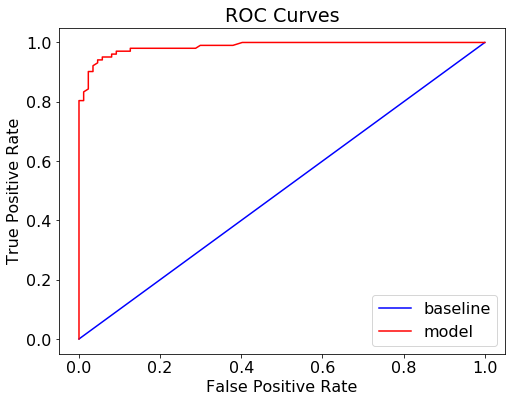

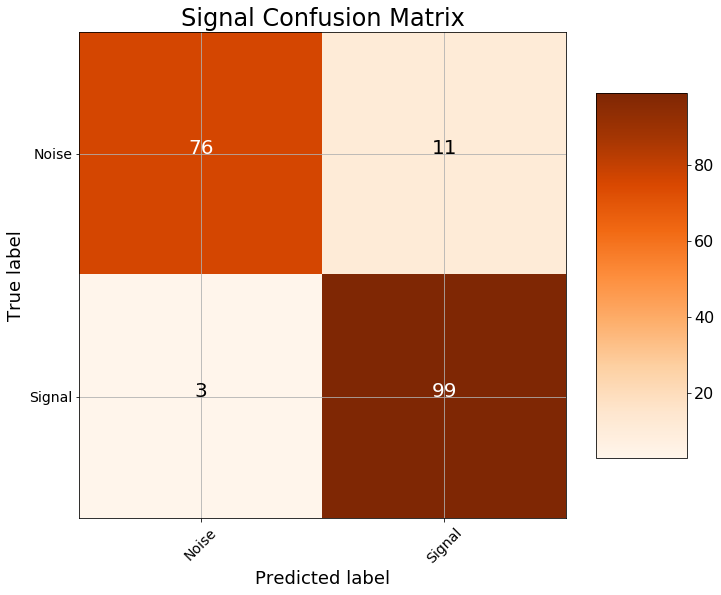

In [16]:
# 30% examples in test data ['Total MaxAmp', 'Split MaxAmp 1', 'Split MaxAmp 2', 'Split MaxAmp 3', 'Split MaxAmp 4', 'SCO', 'Crest Factor', 'Centroid', 'Spread', 'Flatness']
train, test, train_labels, test_labels = train_test_split(learningDataframe.drop(columns=['Flag']), learningDataframe['Flag'], test_size=0.3, random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 250).astype(int),
    'max_depth': [None] + list(np.linspace(3, 30).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.01)),
    'max_leaf_nodes': [None] + list(np.linspace(1, 50, 100).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

#param_grid = {
#    'n_estimators': np.linspace(10, 200).astype(int),
#    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
#    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
#    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 100).astype(int)),
#    'min_samples_split': [2, 5, 10],
#    'bootstrap': [True, False]
#}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = 42)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=42)

# Fit 
rs.fit(train, train_labels)

# Finding best
best_model = rs.best_estimator_
train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]
rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)

# Printing result info and graphics
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

sigp.evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs, test_labels, train_labels)
cm = sigp.confusion_matrix(test_labels, rf_predictions)
sigp.plot_confusion_matrix(cm, classes = ['Noise', 'Signal'],
                      title = 'Signal Confusion Matrix')

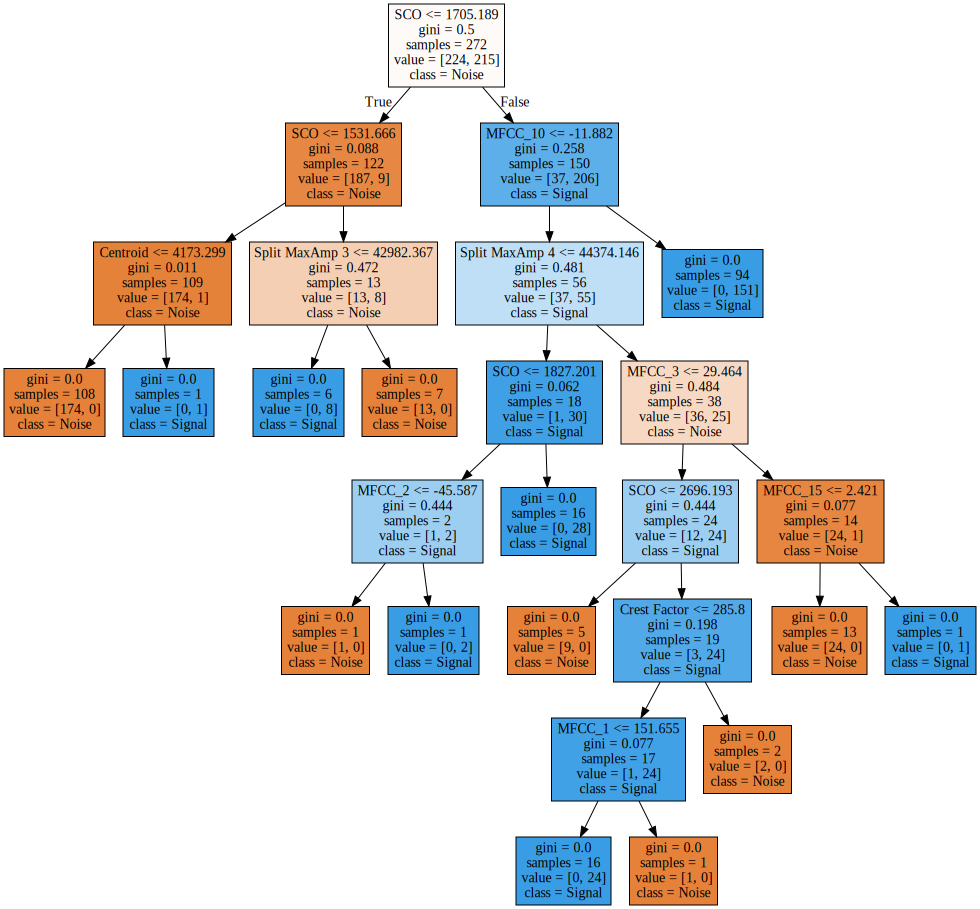

'tree.dot.png'

In [17]:
# Graphviz trees visualization (.estimators_[0] - first tree)
feature_names=learningDataframe.drop(columns=['Flag']).columns
class_names=['Noise', 'Signal']

graph = Source(export_graphviz(best_model.estimators_[0],
                feature_names=feature_names,
                class_names=class_names,
                filled=True,
                rounded=False))
display(SVG(graph.pipe(format='svg')))
graph.render(filename='tree.dot', format='png')

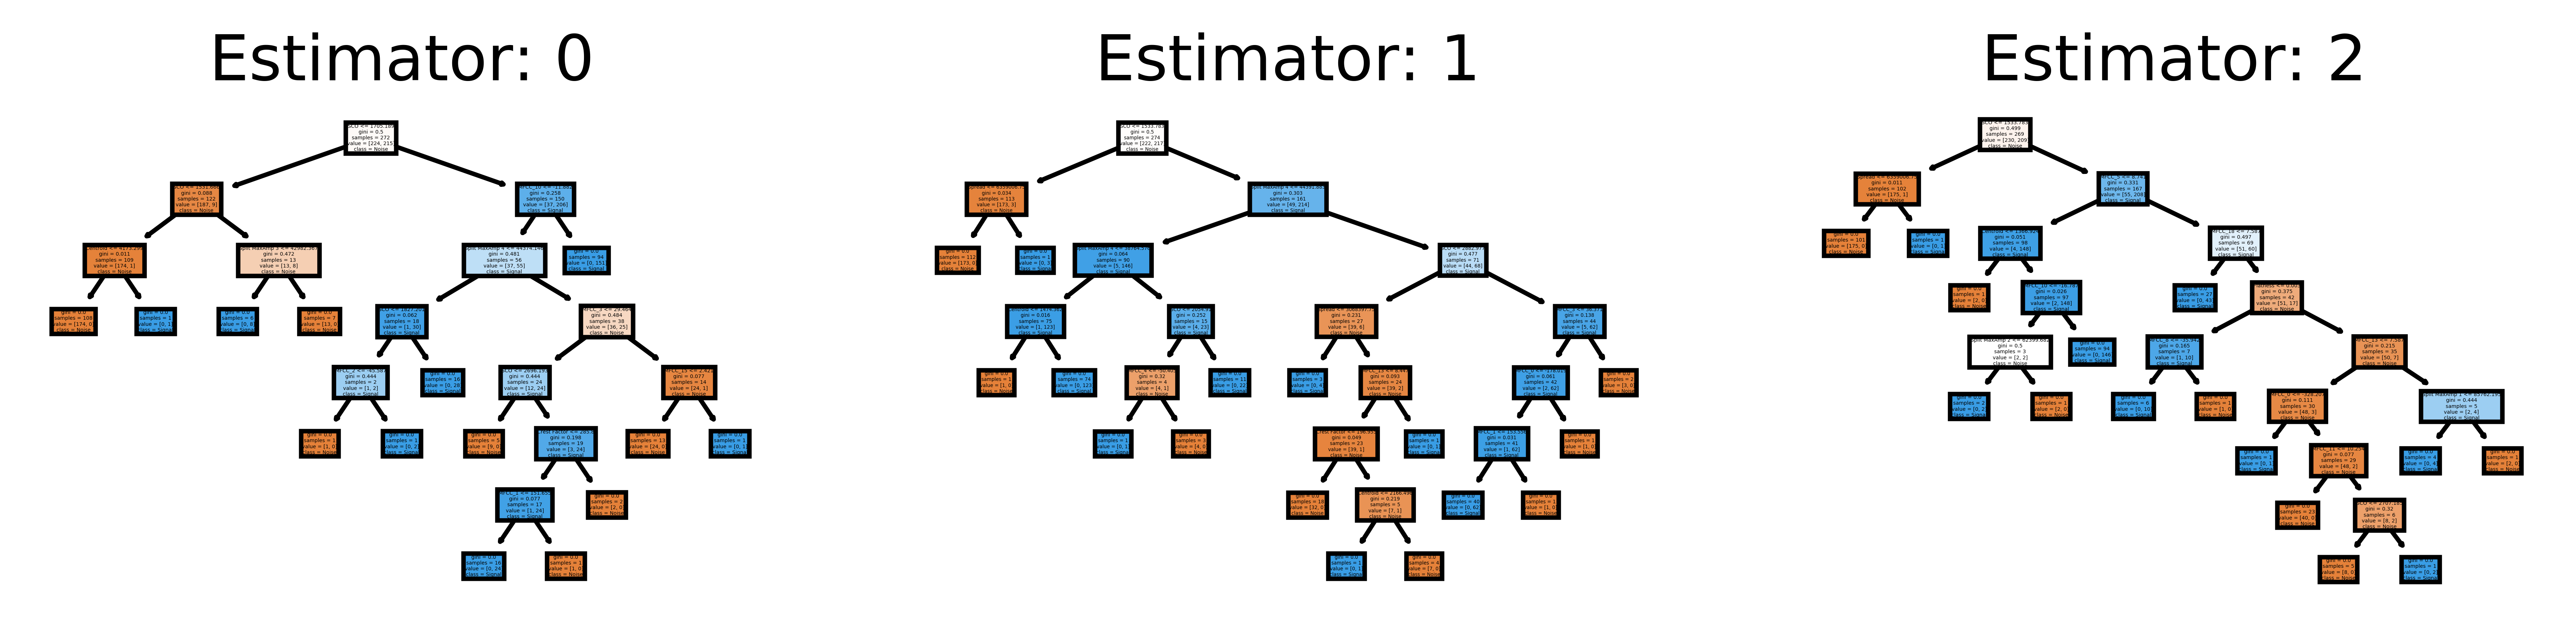

In [18]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (10,2), dpi=900)
for index in range(0, 3):
    tree.plot_tree(best_model.estimators_[index],
                   feature_names = feature_names, 
                   class_names=class_names,
                   filled = True,
                   ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 14)
fig.savefig('rf_3trees.png')

In [19]:
############################################################################## TEST ##############################################################################

In [20]:
classifierFilename = 'classificator.sav'
pickle.dump(best_model, open(classifierFilename, 'wb'))

In [21]:
# Path for packs
psignalPath = r"/home/vaclav/Desktop/Diploma/Dirty Signals/Test/Test02/"

In [22]:
# Extracting the dataframes (data characteristics)
psignalDataFrame = sigp.extract_data(psignalPath)

/home/vaclav/Desktop/Diploma/Notebooks/Classifier/signalprocessing.py:339: RuntimeWarning: divide by zero encountered in log
  return (np.exp((1 / length) * np.sum(np.log(magnitudes)))) / ((1 / length) * np.sum(magnitudes))


In [23]:
#psignalDataFrame = smfccp.pca_dataframe(psignalDataFrame, 25)
#rng = range(0, int((len(list(psignalDataFrame))-1)/2)+1)
#new_cols = ['type_' + str(i) for i in rng] + ['expt_' + str(i) for i in rng]
#psignalDataFrame.columns = new_cols[:len(list(psignalDataFrame))]

In [24]:
psignalDataFrame

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Crest Factor,Centroid,Spread,Flatness,...,MFCC_10,MFCC_11,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19
0,136878.163007,49514.473848,50440.428752,71060.934160,85273.491169,2214.200985,175.652512,2402.367925,4.769173e+06,0.003785,...,-14.995283,8.887760,-1.556240,7.731105,6.333805,2.864420,10.525994,-2.896785,8.410196,-6.658729
1,153366.072596,88953.620750,94829.788426,50961.478833,44580.635616,2201.611684,219.136686,3126.396820,6.189995e+06,0.003666,...,-14.996538,6.494582,3.287429,5.020217,7.432487,-0.264453,9.383091,2.113072,6.041024,-8.057240
2,175622.764669,25518.852096,73312.362696,111797.394657,101808.648212,2222.151950,146.298655,4618.439445,3.830140e+06,0.003433,...,-11.215708,2.460204,2.289179,1.177770,9.903216,0.452476,9.077881,4.446805,5.078933,-6.086461
3,265752.557759,131336.310868,135808.476426,126997.019200,125537.096883,3488.602739,238.680041,4654.100700,6.693495e+06,0.002549,...,-14.191436,6.913034,10.746389,-1.752566,4.956143,5.381353,9.778929,-0.088330,7.397312,-9.252544
4,120201.005886,65412.788332,71148.483469,49956.377500,49446.458882,1690.228062,169.902548,2191.467220,3.235174e+06,0.003761,...,-13.936343,7.424728,-0.379968,5.830671,5.478689,3.530761,9.048565,-2.490987,8.520134,-5.928402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,288320.020820,85643.467129,135419.359455,168255.587678,153588.936417,3320.122474,224.521156,3614.396183,5.966329e+06,0.002696,...,-14.911478,9.069910,4.156929,-1.776568,11.572798,-0.988381,6.700428,0.747697,5.577942,-4.071313
496,73596.986566,8211.218710,34402.775101,42172.207262,42017.765399,1385.274610,119.399179,2414.892478,1.665126e+06,0.003831,...,-9.098672,3.809435,1.309819,5.095041,9.629345,-0.555378,11.078399,0.042995,4.203636,-5.355798
497,228600.202381,104866.248071,149572.557800,116459.526962,27757.205927,2889.285517,168.421239,4732.232034,4.874646e+06,0.002963,...,-7.897702,9.045395,4.017545,-2.807509,8.076990,-0.858247,9.495975,2.026670,6.133890,-6.984187
498,193593.909102,123292.096625,117398.566277,72083.070245,18625.569936,3060.940944,147.527002,5356.361690,4.384689e+06,0.002793,...,-5.118340,-3.238841,10.836316,-1.369262,7.096030,4.253021,3.987610,-0.614972,8.691504,-6.745397


In [25]:
# Predicting the classification
predictedData = best_model.predict(psignalDataFrame)
predictedsignalDataFrame = psignalDataFrame.assign(Flag=predictedData)

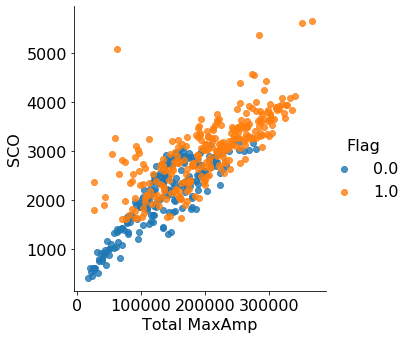

In [26]:
sn.lmplot('Total MaxAmp', 'SCO', data=predictedsignalDataFrame, hue="Flag", fit_reg=False)
#sn.lmplot('type_1', 'type_6', data=learningDataframe, hue="Flag", fit_reg=False)

In [27]:
# Loading wav files for spectrogramms
audiolist = sigp.load_list_of_wav(psignalPath)
temp = audiolist
ppredictedsignalDataFrame = predictedsignalDataFrame.loc[predictedsignalDataFrame['Flag'] == 1]
ppredictedsignalDataFrame.head()

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Crest Factor,Centroid,Spread,Flatness,...,MFCC_11,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19,Flag
1,153366.072596,88953.620750,94829.788426,50961.478833,44580.635616,2201.611684,219.136686,3126.396820,6.189995e+06,0.003666,...,6.494582,3.287429,5.020217,7.432487,-0.264453,9.383091,2.113072,6.041024,-8.057240,1.0
2,175622.764669,25518.852096,73312.362696,111797.394657,101808.648212,2222.151950,146.298655,4618.439445,3.830140e+06,0.003433,...,2.460204,2.289179,1.177770,9.903216,0.452476,9.077881,4.446805,5.078933,-6.086461,1.0
3,265752.557759,131336.310868,135808.476426,126997.019200,125537.096883,3488.602739,238.680041,4654.100700,6.693495e+06,0.002549,...,6.913034,10.746389,-1.752566,4.956143,5.381353,9.778929,-0.088330,7.397312,-9.252544,1.0
5,200143.242271,22842.199511,81634.868178,84387.865121,147771.128966,2681.281077,160.713468,4990.584633,6.012362e+06,0.002877,...,5.981259,4.909084,2.089320,5.487794,4.065164,9.067767,0.073068,9.050041,-11.268538,1.0
6,309957.940024,155458.825993,151349.570825,153997.438998,152229.911121,3904.096865,282.325021,4776.623798,6.403331e+06,0.002415,...,5.024687,5.189766,2.042494,4.433432,4.693380,2.817662,0.662698,13.001268,-13.410610,1.0


No handles with labels found to put in legend.


Signal amount is  277
Signal № 1
Time resolution (s) 0.028444444444444446
Frequency resolution (Hz) 35.15625


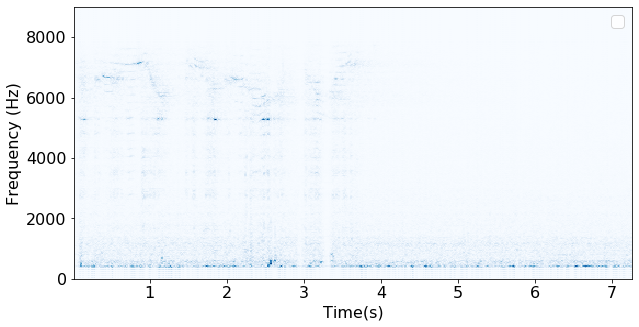

No handles with labels found to put in legend.


Signal № 2
Time resolution (s) 0.028444444444444446
Frequency resolution (Hz) 35.15625


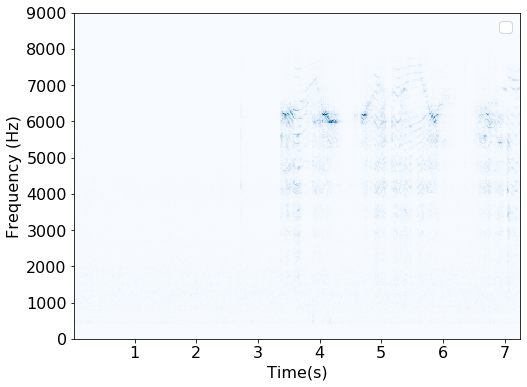

No handles with labels found to put in legend.


Signal № 3
Time resolution (s) 0.028444444444444446
Frequency resolution (Hz) 35.15625


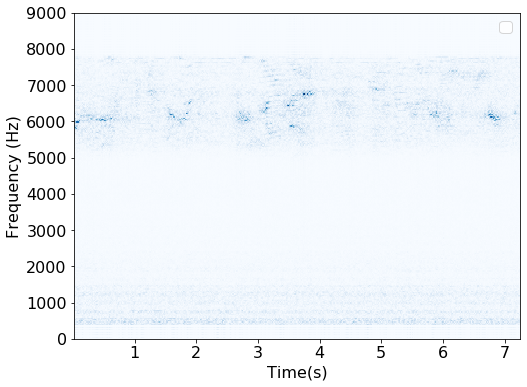

No handles with labels found to put in legend.


Signal № 5
Time resolution (s) 0.028444444444444446
Frequency resolution (Hz) 35.15625


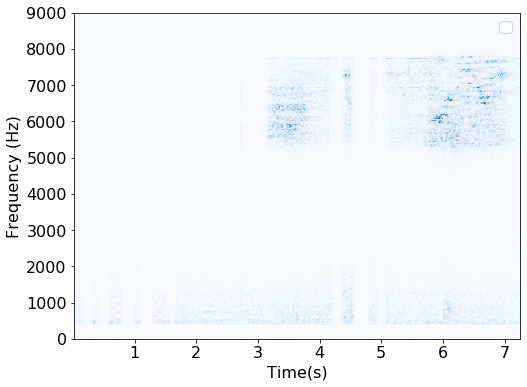

No handles with labels found to put in legend.


Signal № 6
Time resolution (s) 0.028444444444444446
Frequency resolution (Hz) 35.15625


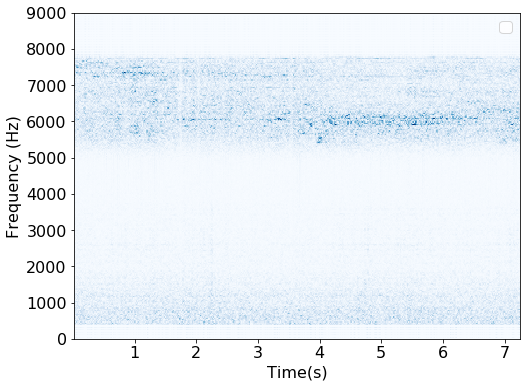

<Figure size 576x432 with 0 Axes>

In [28]:
sigp.plot_all_spectrogramms(audiolist, predictedsignalDataFrame, 512, 0, 5, 1)

In [29]:
audiolist[161].make_audio()

In [ ]:
#sigp.copy_filtered_signal(psignalPath, 45)